In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

from torch.nn import functional as F
from tqdm import tqdm

# 定义VAE模型
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, latent_size * 2) # 输出均值向量和方差向量
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid() # 输出二元数据
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=-1) # 将输出向量拆分为均值向量和方差向量
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std # 重参数化
        return z

    def decode(self, z):
        x = self.decoder(z)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# 定义数据集类
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)


# 定义训练函数
def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    global all_recons_loss
    all_recons_loss = 0
    global all_kld_loss
    all_kld_loss = 0
    recons_loss_function = torch.nn.L1Loss(reduction='mean')
    for x in dataloader:
        x = x.to(device)
        x_recon, mu, log_var = model(x)

        recons_loss = F.mse_loss(x_recon, x)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        kld_weight = 0.3

        
        loss = recons_loss + kld_weight * kld_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_recons_loss += recons_loss
        all_kld_loss += kld_loss

    return total_loss


# 加载数据
kdTree = torch.load("./static/data/CIFAR10/2D_kdTree/2D_kdTree_50000.pt")
data = kdTree.data
dataset = MyDataset(torch.tensor(data, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# 定义超参数和设备
input_size = 2
hidden_size = 64
latent_size = 2
learning_rate = 5e-3
num_epochs = 100
device = torch.device('cuda:1')

# 创建模型和优化器
model = VAE(input_size, hidden_size, latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
num_epochs = tqdm(range(num_epochs))
for epoch in num_epochs:
    train_loss = train(model, dataloader, optimizer, device)
    # test_loss = test(model, dataloader, criterion, device)
    txt = f"Train Loss: {train_loss:.4f}, all_recons_loss: {all_recons_loss:.4f}, all_kld_loss: {all_kld_loss:.4f}"
    num_epochs.set_description(txt)
    num_epochs.update()

# # 生成新数据
# model.eval()
# with torch.no_grad():
#     z = torch.randn(100, latent_size).to(device)
#     x_gen = model.decode(z).cpu().numpy()
#     print(x_gen)

Train Loss: 325109.5421, all_recons_loss: 324165.9688, all_kld_loss: 3145.3696: 100%|██████████| 100/100 [02:43<00:00,  1.64s/it]


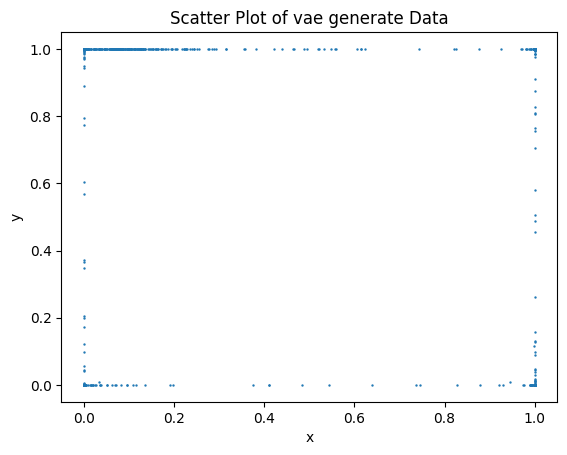

In [2]:
import matplotlib.pyplot as plt
# 生成新数据
model.eval()
with torch.no_grad():
    z = torch.randn(50000, latent_size).to(device)
    x_gen = model.decode(z).cpu().numpy()

plt.scatter(x_gen[:, 0], x_gen[:, 1], s=0.5)
# 添加坐标轴标签和图标题
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of vae generate Data')
plt.show()